# Using age, cholestrol, maximum heart rate and resting blood pressure to classify heart disease patients from Cleveland #

**John Mao, Caitlyn Chan and Ritaksha Roy Burman**


### Introduction ###
Cardiovascular heart diseases are the leading cause of death worldwide, accounting for an estimated 17.9 million casualties each year according to the [WHO.](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1)

Our project seeks to use age, cholesterol, maximum heart rate and resting blood pressure to diagnosis individuals with coronary artery disease, (CAD). CAD occurs when the arteries that deliver blood to the heart is reduced in diameter due to plaque buildup (CDC, 2021).

The goal of this project is to classify patients of whether they have CAD for preventatitive interventions.

The question we wish to answer is: 
**What is the likelihood a patient will have coronary artery disease based on age, sex, cholestrol levels, resting blood pressure and maximum heart rate achieved?**

To answer this, we are using the [heart disease](https://archive.ics.uci.edu/dataset/45/heart+disease) database.

### Preliminary exploratory data analysis ###
We have 303 total rows of data amongst our 5 variables with no observations that contain missing data.



In [3]:
# importing relevant libraries 
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [4]:
# set the seed 
set.seed(1)

# reading the dataframe from a .csv file
heart_data <- read_csv("heart_data.csv") 

# cleaning and wrangling the data frame, selecting relevant columns
heart_data_clean <- heart_data |>
select(chol, trestbps, age, sex, thalach, num) |>
mutate(diagnosis = ifelse(is.na(num), NA, (num>0))) |>
mutate(sex = as_factor(sex))|>
mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0")) |>
mutate(num = as_factor(num)) 

# splitting data into training data set and testing data set 
heart_split <- initial_split(heart_data_clean, prop = 0.75, strata = num)

heart_testing <- testing(heart_split)
heart_training <- training(heart_split)

heart_training
print(paste("Total rows", nrow(heart_data_clean)))
print(paste("Rows with missing data", sum(is.na(heart_data_clean))))



Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chol,trestbps,age,sex,thalach,num,diagnosis
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<lgl>
233,145,63,Male,150,0,FALSE
204,130,41,Female,172,0,FALSE
294,140,56,Female,153,0,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
205,128,55,Female,130,3,TRUE
176,164,59,Male,90,3,TRUE
131,130,57,Male,115,3,TRUE


[1] "Total rows 303"
[1] "Rows with missing data 0"


**Summarizing the Training Data**

Before we visualize and begin our prediction analysis, we need to check that the two predictor classes are balanced so that one class prediction is not favored over the other.

In [13]:
heart_summary_table <- heart_training |>
                    group_by(diagnosis) |>
                    summarize(count = n()) |>
                    arrange(-count)
heart_summary_table

diagnosis,count
<lgl>,<int>
FALSE,124
TRUE,102


Based off the above table, the counts for TRUE and FALSE heart disease diagnoses are balanced in the training set. 

Warning message:
“Using size for a discrete variable is not advised.”


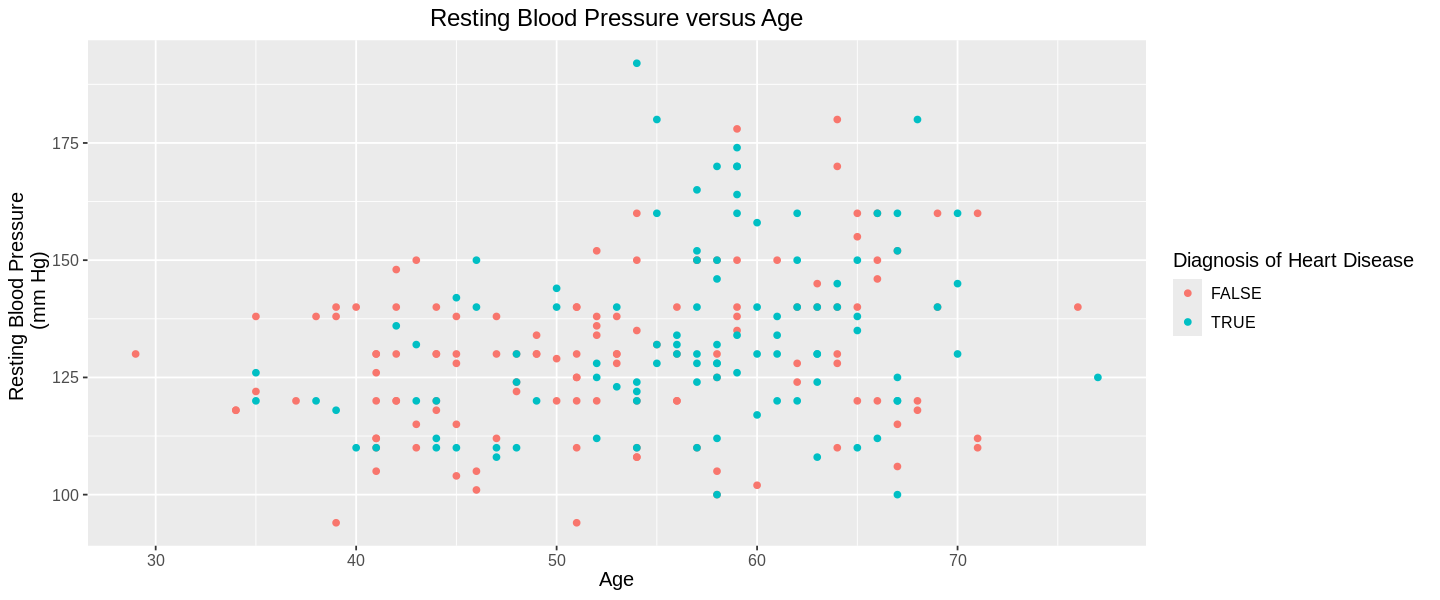

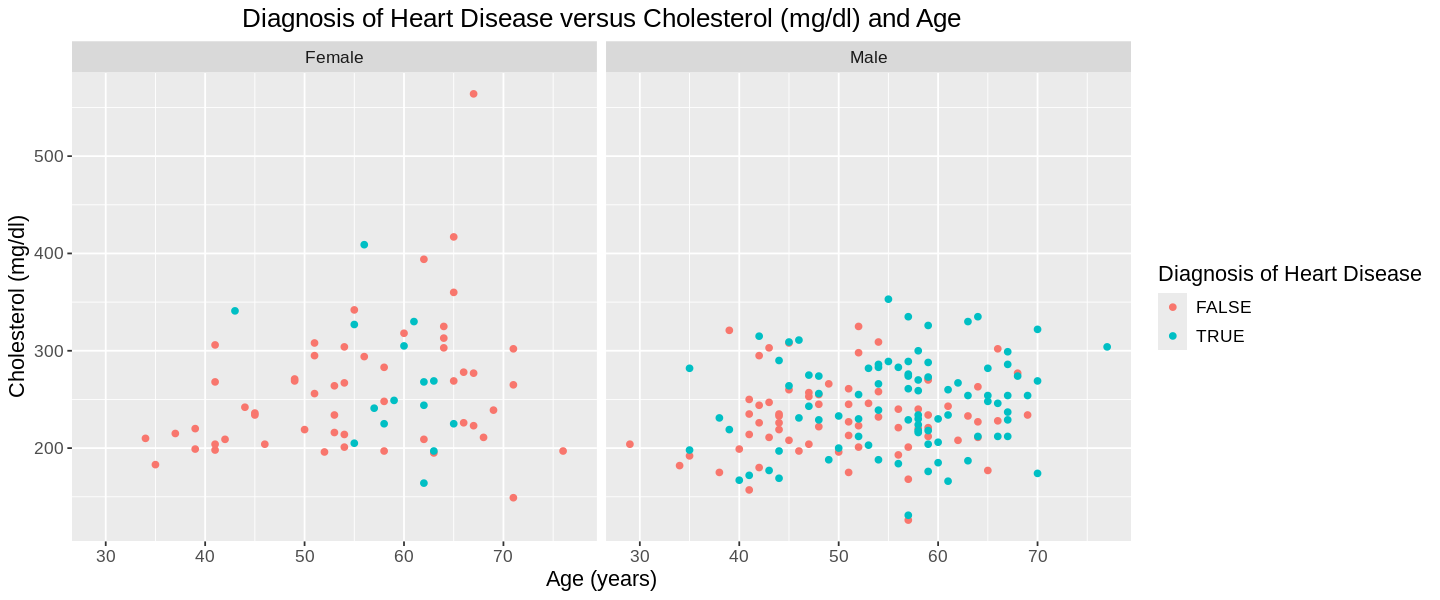

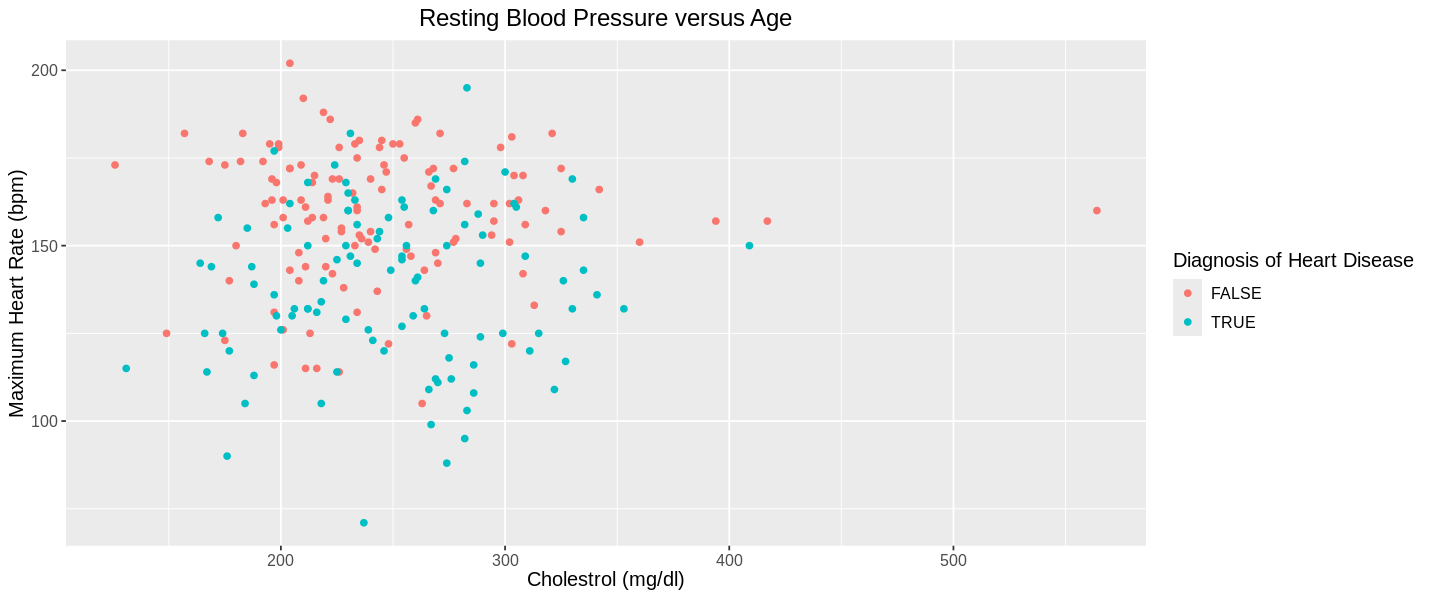

In [12]:
options(repr.plot.width = 12, repr.plot.height = 5)
# Plot the training data

heart_plot1 <- heart_training |> 
            ggplot(aes(x= age, y= trestbps, color = diagnosis)) +
            geom_point()+ 
            labs(x= "Age", y = "Resting Blood Pressure \n (mm Hg)", fill = "Diagnosis of Heart Disease", color = "Diagnosis of Heart Disease", title = "Resting Blood Pressure versus Age", num = "Diagnosis of Heart Disease")+ # rename false and true 
            theme(text = element_text(size = 12))+
            theme(plot.title = element_text(hjust = 0.5))
heart_plot1


heart_plot2 <- heart_training |>
mutate(num = ifelse(num == 0, FALSE, TRUE)) |>
ggplot(aes(x = age, y = chol, color = num)) + 
  geom_point() +
  labs(num = "Diagnosis of Heart Disease",
       color = "Diagnosis of Heart Disease",
       title = "Diagnosis of Heart Disease versus Cholesterol (mg/dl) and Age",
       y = "Cholesterol (mg/dl)", x= "Age (years)") +
    theme(text = element_text(size = 13)) +
    scale_size_discrete(range = c(1, 2)) +
    facet_grid(cols = vars(sex))+
    theme(plot.title = element_text(hjust = 0.5))


heart_plot2

heart_plot3 <- heart_training |> 
            ggplot(aes(x= chol, y= thalach, color = diagnosis)) +
            geom_point()+ 
            labs(x= "Cholestrol (mg/dl)", y = "Maximum Heart Rate (bpm)", fill = "Diagnosis of Heart Disease", color = "Diagnosis of Heart Disease", title = "Resting Blood Pressure versus Age", num = "Diagnosis of Heart Disease")+ # rename false and true 
            theme(text = element_text(size = 12))+
            theme(plot.title = element_text(hjust = 0.5))
heart_plot3




### Methods ###
We will be using variables from the Heart Disease Database, in particular the Cleaveland database:
- chol : serium cholestoral in mg/dl
- age : age in years
- trestbps : resting blood pressure (in mm Hg on admission to hospital)
- sex
- num : 0 = unafflicted by disease, (1,2,3,4) showing presense of heart disease.
- thalach: maximum heart rate achieved (bpm) 

To tidy the data, we have changed the sex and num (presense of heart disease) to factors. **num** uses integers 1 to 4 to determine diagnosis of CAD, thus we have created a new column which sets presence of heart disease (**num** > 0) to TRUE and absence (**num** = 0) to FALSE. 

The dataframe has been split into a training and testing set. The data is stratified by the categorical variable, **diagnosis**. 

To visualize the results of our data analysis, scatterplots of different numerical variables were plotted against eachother. 

* In the plot of **trestbp vs age**

A distinct region of resting blood pressure is high in the ages of 50 to 70. 

* In the plot of **chol vs age**

Women in the ages of 55-65 appear to be at higher risk whereas men appear to be at risk from ages 45 - 70.

* In the plot of **thalach vs chol**

There are distinct regions of TRUE and FALSE, and a mix of both. 

These relationships and distribution determined selection of **trestbp, age, thalach and chol** as predictors. 

We are going to train and classify using K-nearest neighbours to determine if a new patient is likely to be afflicted by heart disease.

### Expected Outcomes and Significance ##
We expect to see a positive trend with resting blood pressure and age. We also expect to see that on average, those  with heart diseases will have higher blood pressures.
We wish to explore how sex impacts an individual's potential risk.

This data anaylsis could be advantageous to enhance timely diagnosis of cardiovascular disease to help implement interventions and recognize risk factors. 

Future questions this could lead to: 
1. Which of the factors have the greatest influence on diagnosis of CAD?
2. What are some preventative measures one can take to minimize risk of heart disease?


### Bibliography ### 

Detrano, R., Janois, A., Steinbrunn, W., Pfisterer, Matthias., Schmid, Johann-Jakob., Sandhu, S., Guppy, KH., Lee, S., Froelicher, V. (1988). International Application of a New Probability Algorithm for the Diagnosis of Coronary Artery Disease. *The American Journal of Cardiology*, 64(1), 304-309.  https://doi.org/10.24432/C52P4X.

Coronary Artery Disease. (2021, July 19). Centers for Disease Control and Prevention (CDC). https://www.cdc.gov/heartdisease/coronary_ad.htm


Janosi, A ., Steinbrunn, W., Pfisterer, M., and Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

World Health Organization. (n.d.). https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1. 




    